# Diabetes Readmission Project: Data Exploration and Preprocessing

This project focuses on data from 130 US hospitals to predict early readmission in diabetic patients within 30 days. The project workflow includes:
1. Data Exploration and Clustering
2. Data Preprocessing and Feature Engineering
3. Algorithm Selection and Model Training
4. Result Analysis
5. Visualization
6. Web Integration


## Step 1: Importing Libraries

In [1]:
pip install dash flask plotly requests scikit-learn seaborn

Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install category_encoders

In [3]:
!pip install imbalanced-learn

In [4]:
import pandas as pd
import numpy as np
import requests
from category_encoders import TargetEncoder
from flask import Flask, request, jsonify
import dash
from dash import dcc, html
import plotly.express as px
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

## Step 2: Data Preprocessing & Feature Engineering

Handling missing values, mapping categorical IDs, encoding features, and creating additional useful features.

Inspecting the first few rows of the dataset:
   encounter_id  patient_nbr             race  gender      age weight  \
0       2278392      8222157        Caucasian  Female   [0-10)      ?   
1        149190     55629189        Caucasian  Female  [10-20)      ?   
2         64410     86047875  AfricanAmerican  Female  [20-30)      ?   
3        500364     82442376        Caucasian    Male  [30-40)      ?   
4         16680     42519267        Caucasian    Male  [40-50)      ?   

   admission_type_id  discharge_disposition_id  admission_source_id  \
0                  6                        25                    1   
1                  1                         1                    7   
2                  1                         1                    7   
3                  1                         1                    7   
4                  1                         1                    7   

   time_in_hospital  ... citoglipton insulin  glyburide-metformin  \
0                 1

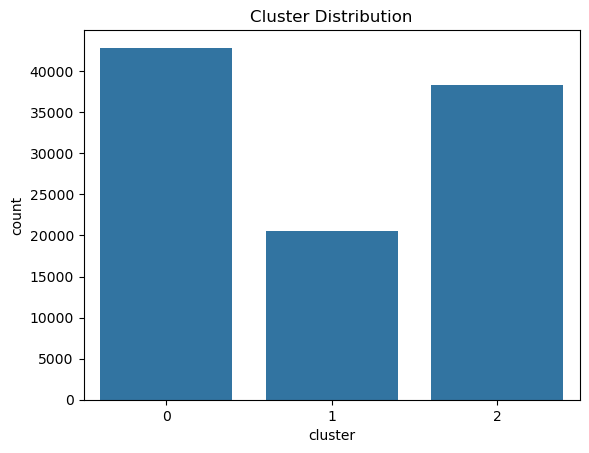


Class distribution in the 'readmitted' column:
NO     54864
>30    35545
<30    11357
Name: readmitted, dtype: int64


In [5]:
# Loading datasets
diabetic_data = pd.read_csv('diabetic_data.csv')
ids_mapping = pd.read_csv('IDS_mapping.csv')

# Inspecting the first few rows of the dataset to check data integrity
print("Inspecting the first few rows of the dataset:")
print(diabetic_data.head())  # Display the first few rows

# Initial exploration
print("Diabetic Data Shape:", diabetic_data.shape)
print("Missing Values Count:\n", diabetic_data.isnull().sum())
print("Data Types:\n", diabetic_data.dtypes)

# Basic statistics
print("Basic Statistics:\n", diabetic_data.describe(include='all'))

# Clustering analysis to identify patient segments
# Replace '?' placeholders, and perform KMeans clustering on numeric data only
diabetic_data.replace('?', np.nan, inplace=True)
numeric_data = diabetic_data.select_dtypes(include=[np.number]).fillna(0)
kmeans = KMeans(n_clusters=3, random_state=42)
diabetic_data['cluster'] = kmeans.fit_predict(numeric_data)

# Visualizing clusters
sns.countplot(data=diabetic_data, x='cluster')
plt.title("Cluster Distribution")
plt.show()

# Checking for class imbalance in the target variable 'readmitted'
print("\nClass distribution in the 'readmitted' column:")
print(diabetic_data['readmitted'].value_counts())

## Summary Statistics and Exploratory Data Analysis

In this step, we perform a detailed exploratory analysis to better understand the structure and distribution of the data, focusing on both categorical and numerical features.

### 1. Summary Statistics

We begin by calculating summary statistics for the dataset, including measures such as mean, median, and standard deviation for numerical features. This step helps us quickly identify key characteristics and potential issues within the data.

### 2. Visualizing Important Categorical Features

We are visualizing the distribution of important categorical features to understand their influence on patient admissions and outcomes. The main categorical features of interest include:
- **Gender**: Visualizing the distribution of patients by gender.
By visualizing gender distribution, we can assess whether there’s a balance in the dataset and examine if one gender has higher readmission rates or other outcomes, which might inform gender-specific interventions or model adjustments.
- **Admission Type** (`admission_type_id`): Exploring the types of patient admissions.
By exploring different admission types, we can determine if certain types are linked to higher readmission rates or different patient outcomes, which could inform both predictive modeling and targeted healthcare strategies.
- **Discharge Disposition** (`discharge_disposition_id`): Understanding discharge categories and their frequencies.
By understanding the frequencies and readmission rates associated with different discharge dispositions, we can identify high-risk groups or common discharge settings linked to readmission, which might suggest areas for intervention or resource allocation.

Interesting finding. Usually IDs themselves are just codes or placeholders without intrinsic meaning. However, in this dataset, these ID fields represent categorical groups rather than unique identifiers, so they can indeed help in predicting readmissions.

### 3. Visualizing Distribution of Numerical Features

Next, we are exploring the distribution of numerical features, which can reveal patterns and identify any skewness or outliers in the data. This would help inform potential data transformations that may be needed for model training.

### 4. Correlation Matrix and Heatmap

To understand the relationships between numerical features, we are calculating a correlation matrix and visualizing it with a heatmap. This heatmap highlights any strong positive or negative correlations, aiding in feature selection by identifying redundancies or dependencies in the data.

Numerical Features Summary:
        encounter_id   patient_nbr  admission_type_id  \
count  1.017660e+05  1.017660e+05      101766.000000   
mean   1.652016e+08  5.433040e+07           2.024006   
std    1.026403e+08  3.869636e+07           1.445403   
min    1.252200e+04  1.350000e+02           1.000000   
25%    8.496119e+07  2.341322e+07           1.000000   
50%    1.523890e+08  4.550514e+07           1.000000   
75%    2.302709e+08  8.754595e+07           3.000000   
max    4.438672e+08  1.895026e+08           8.000000   

       discharge_disposition_id  admission_source_id  time_in_hospital  \
count             101766.000000        101766.000000     101766.000000   
mean                   3.715642             5.754437          4.395987   
std                    5.280166             4.064081          2.985108   
min                    1.000000             1.000000          1.000000   
25%                    1.000000             1.000000          2.000000   
50%                   

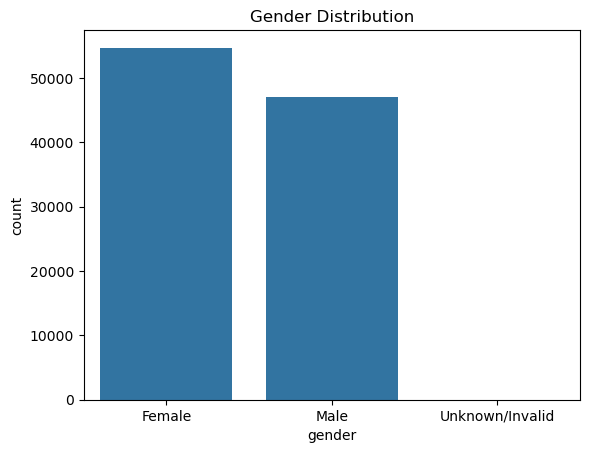

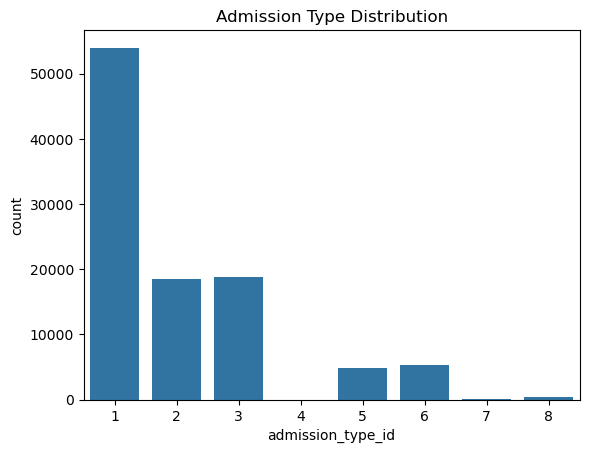

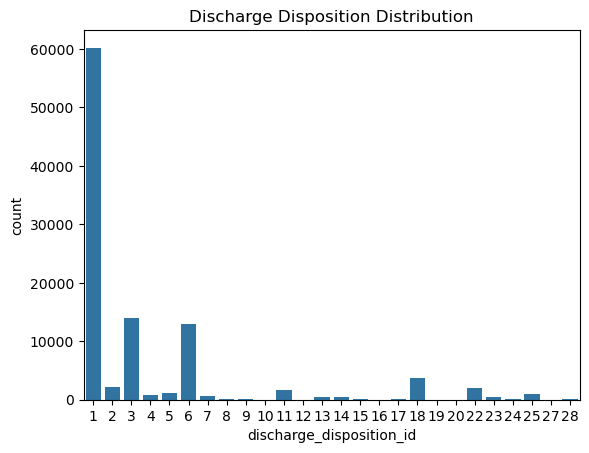

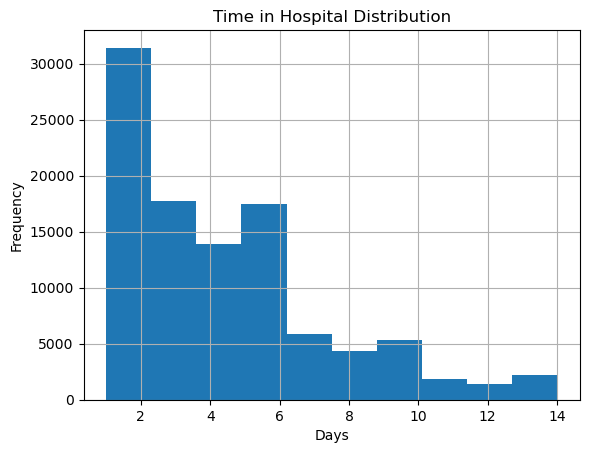

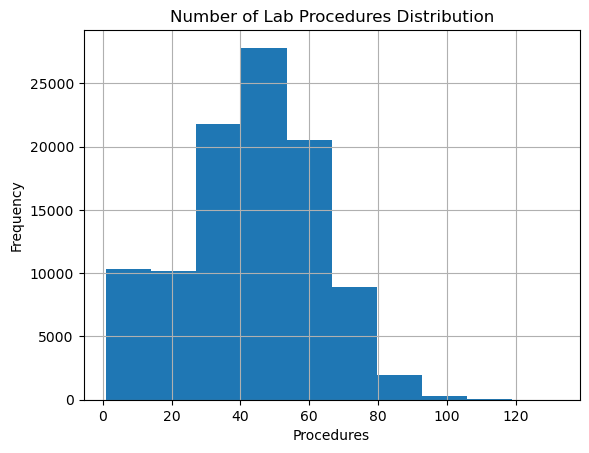

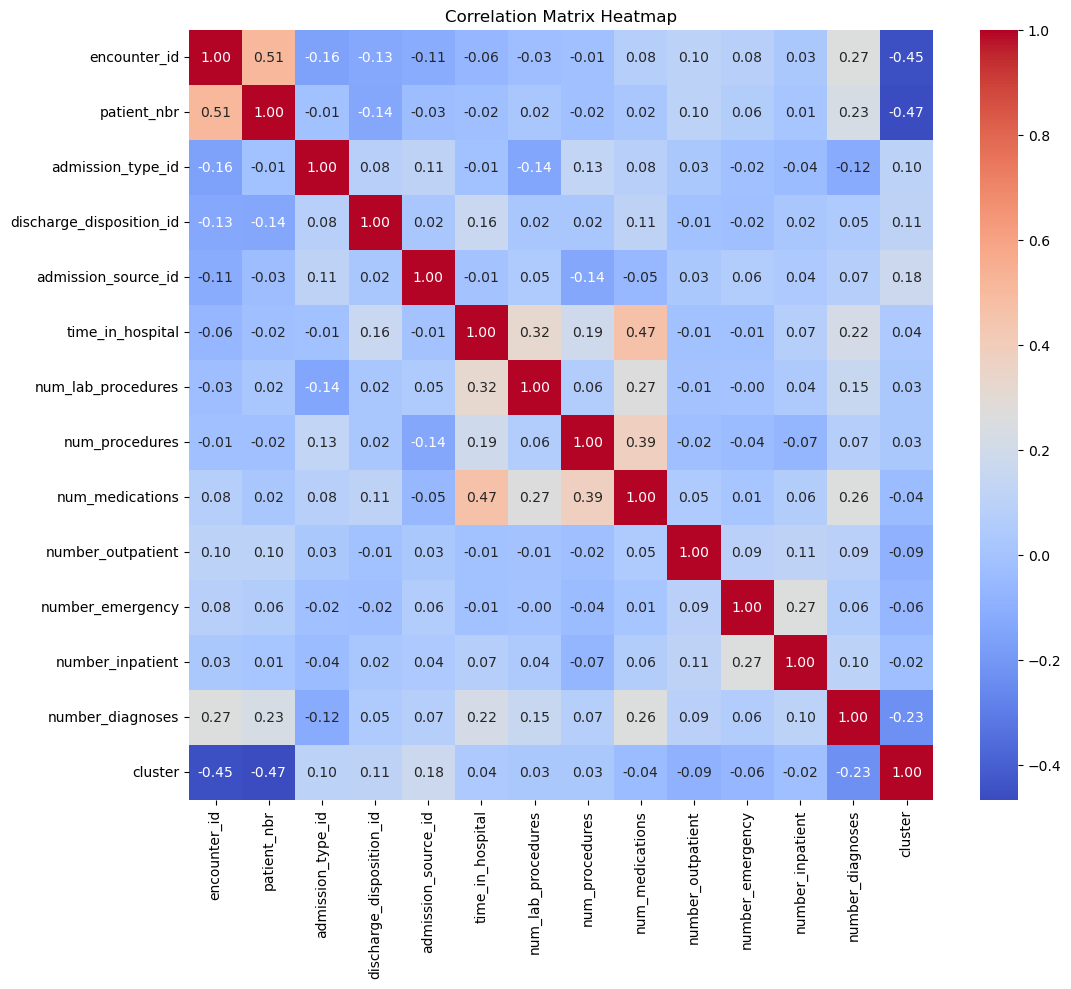

In [6]:
# Summarizing numerical features only
print("Numerical Features Summary:\n", diabetic_data.describe())

# Summarizing categorical features, using include='object' for object (categorical) columns
print("Categorical Features Summary:\n", diabetic_data.describe(include='object'))

sns.countplot(data=diabetic_data, x='gender')
plt.title("Gender Distribution")
plt.show()

sns.countplot(data=diabetic_data, x='admission_type_id')
plt.title("Admission Type Distribution")
plt.show()

sns.countplot(data=diabetic_data, x='discharge_disposition_id')
plt.title("Discharge Disposition Distribution")
plt.show()


diabetic_data['time_in_hospital'].hist(bins=10)
plt.title("Time in Hospital Distribution")
plt.xlabel("Days")
plt.ylabel("Frequency")
plt.show()

diabetic_data['num_lab_procedures'].hist(bins=10)
plt.title("Number of Lab Procedures Distribution")
plt.xlabel("Procedures")
plt.ylabel("Frequency")
plt.show()


# Selecting only numeric columns for the correlation matrix
numeric_data = diabetic_data.select_dtypes(include=[np.number])

# Generating the correlation matrix for numeric columns only
correlation_matrix = numeric_data.corr()

# Plotting the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix Heatmap")
plt.show()

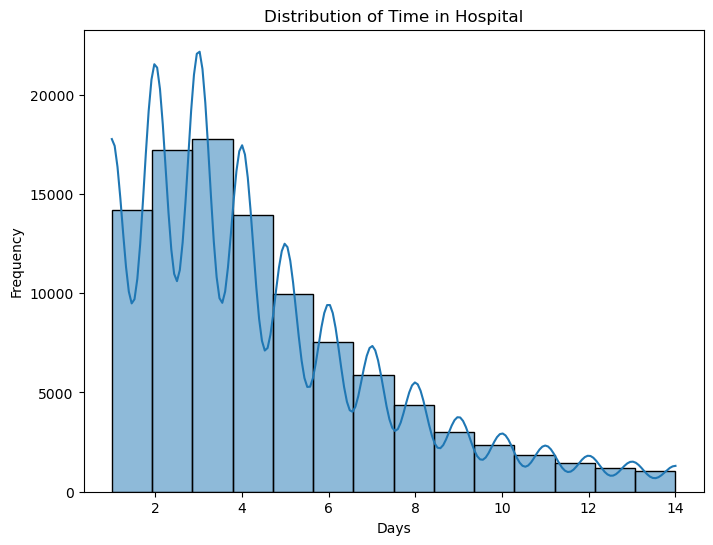

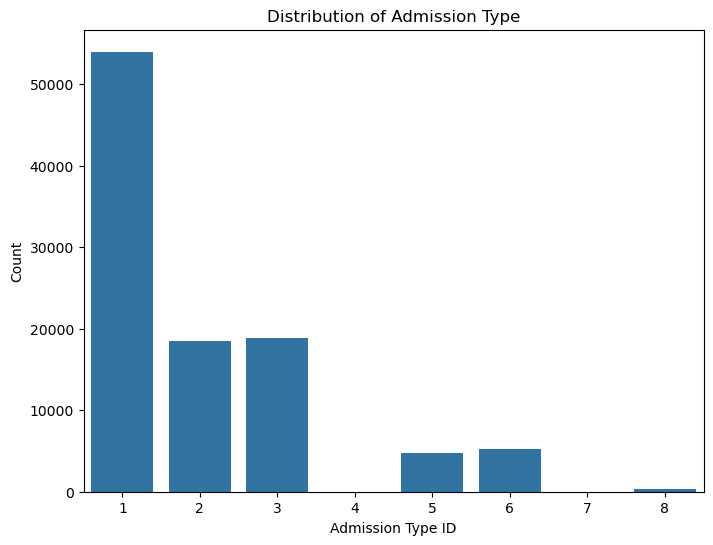

In [7]:
# Example: Distribution plot for 'time_in_hospital'
plt.figure(figsize=(8, 6))
sns.histplot(diabetic_data['time_in_hospital'], bins=14, kde=True)
plt.title("Distribution of Time in Hospital")
plt.xlabel("Days")
plt.ylabel("Frequency")
plt.show()



# Example: Distribution of 'admission_type_id'
plt.figure(figsize=(8, 6))
sns.countplot(data=diabetic_data, x='admission_type_id')
plt.title("Distribution of Admission Type")
plt.xlabel("Admission Type ID")
plt.ylabel("Count")
plt.show()

## Step 3: Data Cleaning and Preprocessing

### 3.1 Data Cleaning

In this step, we are cleaning the data by handling missing values, mapping categorical IDs, encoding features, and creating additional useful features to prepare the dataset for modeling.

#### Mapping Categorical IDs

Categorical ID features (such as `admission_type_id`, `discharge_disposition_id`, and `admission_source_id`) will be mapped to descriptive categories where possible. This enhances interpretability and ensures that the model can recognize important groupings related to patient admissions and discharge processes.

#### Handling Missing Values and Replacing Placeholders

We start by replacing any placeholder values (`?`) in the dataset with `NaN`. This ensures they are accurately recognized as missing values, allowing for appropriate handling in the next steps.

#### Encoding Categorical Features

Once categorical IDs are mapped to categories, they will be encoded to make them usable by the model. This may include one-hot encoding or ordinal encoding depending on the nature of each feature.

#### Creating Additional Features

Based on our basic domain knowledge, we are engineering new features if needed to enrich the dataset. These could include transformations, aggregations, or interactions between features that may enhance the model’s predictive power.

## Mapping Categorical IDs to Descriptive Labels

To enhance interpretability, we map categorical IDs in the dataset (e.g., `admission_type_id`, `discharge_disposition_id`, and `admission_source_id`) to descriptive labels. The mappings are provided in `IDS_mapping.csv`, which contains information about each ID’s corresponding label. After mapping, we drop the original ID columns as they are no longer needed.

The mapping process:
1. Filters each type of ID from `IDS_mapping.csv`.
2. Creates a dictionary to map each ID to its description.
3. Applies these mappings to the main dataset (`diabetic_data`) to replace the numeric IDs with human-readable labels.

In [8]:
# Check the columns in IDS_mapping.csv to verify the correct names
print("Columns in IDS_mapping.csv:", ids_mapping.columns)
print(ids_mapping.head())  # Display first few rows to confirm structure

Columns in IDS_mapping.csv: Index(['admission_type_id', 'description'], dtype='object')
  admission_type_id    description
0                 1      Emergency
1                 2         Urgent
2                 3       Elective
3                 4        Newborn
4                 5  Not Available


In [9]:
print("Columns in diabetic_data:", diabetic_data.columns)

Columns in diabetic_data: Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted',
       'cluster'],
      dtype='object')


In [10]:
print(ids_mapping.head(68))

   admission_type_id                                        description
0                  1                                          Emergency
1                  2                                             Urgent
2                  3                                           Elective
3                  4                                            Newborn
4                  5                                      Not Available
..               ...                                                ...
62                22   Transfer from hospital inpt/same fac reslt in...
63                23                          Born inside this hospital
64                24                         Born outside this hospital
65                25            Transfer from Ambulatory Surgery Center
66                26                              Transfer from Hospice

[67 rows x 2 columns]


Interesting finding. It looks like IDS_mapping.csv contains a mix of values for different mappings under the same column, which might need to be separated based on type. Let's handle this by isolating only the rows that are relevant to admission_type_id, since diabetic_data only has admission_type available for mapping.

In [11]:
# Separate each ID section based on row ranges and rename columns
admission_type_df = ids_mapping.iloc[0:8].copy()
admission_type_df.columns = ['admission_type_id', 'description']

discharge_disposition_df = ids_mapping.iloc[10:41].copy()
discharge_disposition_df.columns = ['discharge_disposition_id', 'description']

admission_source_df = ids_mapping.iloc[42:68].copy()
admission_source_df.columns = ['admission_source_id', 'description']

# Convert each DataFrame to a dictionary for mapping
admission_type_mapping = admission_type_df.set_index('admission_type_id')['description'].to_dict()
discharge_disposition_mapping = discharge_disposition_df.set_index('discharge_disposition_id')['description'].to_dict()
admission_source_mapping = admission_source_df.set_index('admission_source_id')['description'].to_dict()

# Display mappings to verify
print("Admission Type Mapping:", admission_type_mapping)
print("Discharge Disposition Mapping:", discharge_disposition_mapping)
print("Admission Source Mapping:", admission_source_mapping)

Admission Type Mapping: {'1': 'Emergency', '2': 'Urgent', '3': 'Elective', '4': 'Newborn', '5': 'Not Available', '6': nan, '7': 'Trauma Center', '8': 'Not Mapped'}
Discharge Disposition Mapping: {'1': 'Discharged to home', '2': 'Discharged/transferred to another short term hospital', '3': 'Discharged/transferred to SNF', '4': 'Discharged/transferred to ICF', '5': 'Discharged/transferred to another type of inpatient care institution', '6': 'Discharged/transferred to home with home health service', '7': 'Left AMA', '8': 'Discharged/transferred to home under care of Home IV provider', '9': 'Admitted as an inpatient to this hospital', '10': 'Neonate discharged to another hospital for neonatal aftercare', '11': 'Expired', '12': 'Still patient or expected to return for outpatient services', '13': 'Hospice / home', '14': 'Hospice / medical facility', '15': 'Discharged/transferred within this institution to Medicare approved swing bed', '16': 'Discharged/transferred/referred another institutio

In [12]:
# Replace 'NULL' with a default value like 'Unknown' in the description column
ids_mapping['description'] = ids_mapping['description'].replace('NULL', 'Unknown')

# Proceed to create separate DataFrames for each mapping section as before
admission_type_df = ids_mapping.iloc[0:8].copy()
admission_type_df.columns = ['admission_type_id', 'description']

discharge_disposition_df = ids_mapping.iloc[8:35].copy()
discharge_disposition_df.columns = ['discharge_disposition_id', 'description']

admission_source_df = ids_mapping.iloc[35:68].copy()
admission_source_df.columns = ['admission_source_id', 'description']

# Create mapping dictionaries
admission_type_mapping = admission_type_df.set_index('admission_type_id')['description'].to_dict()
discharge_disposition_mapping = discharge_disposition_df.set_index('discharge_disposition_id')['description'].to_dict()
admission_source_mapping = admission_source_df.set_index('admission_source_id')['description'].to_dict()

In [13]:
# Load diabetic_data (if not already loaded)
diabetic_data = pd.read_csv('diabetic_data.csv')

# Convert columns in diabetic_data to strings for consistent mapping with dictionary keys
diabetic_data['admission_type_id'] = diabetic_data['admission_type_id'].astype(str)
diabetic_data['discharge_disposition_id'] = diabetic_data['discharge_disposition_id'].astype(str)
diabetic_data['admission_source_id'] = diabetic_data['admission_source_id'].astype(str)

# Map each ID column to its description using the created dictionaries
diabetic_data['admission_type'] = diabetic_data['admission_type_id'].map(admission_type_mapping).fillna("Unknown")
diabetic_data['discharge_disposition'] = diabetic_data['discharge_disposition_id'].map(discharge_disposition_mapping).fillna("Unknown")
diabetic_data['admission_source'] = diabetic_data['admission_source_id'].map(admission_source_mapping).fillna("Unknown")

# Verify the mapping by checking a few rows
print("\nSample data after mapping:")
print(diabetic_data[['admission_type', 'discharge_disposition', 'admission_source']].head())


Sample data after mapping:
  admission_type discharge_disposition     admission_source
0        Unknown            Not Mapped   Physician Referral
1      Emergency    Discharged to home       Emergency Room
2      Emergency    Discharged to home       Emergency Room
3      Emergency    Discharged to home       Emergency Room
4      Emergency    Discharged to home       Emergency Room


In [14]:
# Print the full DataFrame (only for small datasets)
print(diabetic_data[['admission_type', 'discharge_disposition', 'admission_source']])

       admission_type          discharge_disposition  \
0             Unknown                     Not Mapped   
1           Emergency             Discharged to home   
2           Emergency             Discharged to home   
3           Emergency             Discharged to home   
4           Emergency             Discharged to home   
...               ...                            ...   
101761      Emergency  Discharged/transferred to SNF   
101762      Emergency  Discharged/transferred to ICF   
101763      Emergency             Discharged to home   
101764         Urgent  Discharged/transferred to SNF   
101765      Emergency             Discharged to home   

                                       admission_source  
0                                    Physician Referral  
1                                        Emergency Room  
2                                        Emergency Room  
3                                        Emergency Room  
4                                    

In [15]:
# After mappings have been applied to create descriptive columns
# Dropping the original numeric ID columns
diabetic_data.drop(['admission_type_id', 'discharge_disposition_id', 'admission_source_id'], axis=1, inplace=True)

# One-hot encoding the descriptive columns for model readiness
diabetic_data_encoded = pd.get_dummies(diabetic_data, columns=['admission_type', 'discharge_disposition', 'admission_source'])

# Checking the resulting DataFrame
print("Data after dropping ID columns and encoding descriptive labels:")
print(diabetic_data_encoded.head())

Data after dropping ID columns and encoding descriptive labels:
   encounter_id  patient_nbr             race  gender      age weight  \
0       2278392      8222157        Caucasian  Female   [0-10)      ?   
1        149190     55629189        Caucasian  Female  [10-20)      ?   
2         64410     86047875  AfricanAmerican  Female  [20-30)      ?   
3        500364     82442376        Caucasian    Male  [30-40)      ?   
4         16680     42519267        Caucasian    Male  [40-50)      ?   

   time_in_hospital payer_code         medical_specialty  num_lab_procedures  \
0                 1          ?  Pediatrics-Endocrinology                  41   
1                 3          ?                         ?                  59   
2                 2          ?                         ?                  11   
3                 2          ?                         ?                  44   
4                 1          ?                         ?                  51   

   ...  admissio

In [16]:
# Check unique values in each descriptive column before encoding
print("Unique values in admission_type:", diabetic_data['admission_type'].unique())
print("Unique values in discharge_disposition:", diabetic_data['discharge_disposition'].unique())
print("Unique values in admission_source:", diabetic_data['admission_source'].unique())

# After encoding, check for a few specific columns to confirm that the encoding was accurate
print("Sample of one-hot encoded columns:")
print(diabetic_data_encoded.filter(regex='admission_source').head())

Unique values in admission_type: ['Unknown' 'Emergency' 'Urgent' 'Elective' 'Newborn' 'Not Available'
 'Not Mapped' 'Trauma Center']
Unique values in discharge_disposition: ['Not Mapped' 'Discharged to home' 'Discharged/transferred to SNF'
 'Discharged/transferred to home with home health service'
 'Discharged/transferred to another short term hospital'
 'Discharged/transferred to another type of inpatient care institution'
 'Expired' 'Left AMA'
 'Neonate discharged to another hospital for neonatal aftercare'
 'Discharged/transferred to ICF' 'Hospice / medical facility' 'Unknown'
 'Discharged/transferred to home under care of Home IV provider'
 'Hospice / home'
 'Still patient or expected to return for outpatient services'
 'Discharged/transferred/referred another institution for outpatient services'
 'Discharged/transferred/referred to this institution for outpatient services'
 'Discharged/transferred to another rehab fac including rehab units of a hospital .'
 'Discharged/transferred

Interesting finding. It looks like our output has many columns filled with zeros, which indicates that one-hot encoding created a large number of sparse columns (many columns with mostly zeros). This mostly happens because categorical features contain many unique values, but only a few values appear frequently. We need to adjust approach further.

## Replacing Placeholders (`?`) with `NaN`

Replacing any placeholders (`?`) in the dataset with `NaN` to ensure they are accurately recognized as missing values.

In [17]:
# Step 1: Replace '?' placeholders with NaN to standardize missing values
print("Replacing '?' placeholders with NaN...")
diabetic_data.replace('?', np.nan, inplace=True)

# Step 2: Checking for columns with missing values
missing_counts = diabetic_data.isnull().sum()
missing_counts = missing_counts[missing_counts > 0]  # Filter columns with missing values only

# Print the columns with missing values
if missing_counts.empty:
    print("No missing values were found after replacement.")
else:
    print("Missing values were identified in the following columns after replacing placeholders:")
    print(missing_counts)

# Summary of missing values
print(f"\nTotal columns with missing values: {len(missing_counts)}")
print("Missing values replacement and reporting completed.\n")

# Step 3: Drop irrelevant columns with high missingness (over 90%)
columns_to_drop = ['weight', 'payer_code']
existing_columns_to_drop = [col for col in columns_to_drop if col in diabetic_data.columns]
diabetic_data.drop(columns=existing_columns_to_drop, inplace=True)
print("Dropped columns with high missingness:", existing_columns_to_drop)

# Step 4: Fill missing values in categorical columns with the most frequent (mode) value
categorical_columns_to_impute = ['race', 'medical_specialty']
for column in categorical_columns_to_impute:
    if column in diabetic_data.columns:  # Ensure column exists before imputing
        mode_value = diabetic_data[column].mode()[0]
        diabetic_data[column] = diabetic_data[column].fillna(mode_value)  # Assign back to avoid warning
        print(f"Filled missing values in '{column}' with the most frequent value: {mode_value}")

# Step 5: Impute 'max_glu_serum' and 'A1Cresult' columns with 'None' to indicate unmeasured values
for column in ['max_glu_serum', 'A1Cresult']:
    diabetic_data[column] = diabetic_data[column].fillna('None')  # Assign back to avoid warning
    print(f"Filled missing values in '{column}' with 'None'")

# Step 6: Impute missing values in diagnosis codes with the most frequent value
diagnosis_columns = ['diag_1', 'diag_2', 'diag_3']
for column in diagnosis_columns:
    if column in diabetic_data.columns:
        mode_value = diabetic_data[column].mode()[0]
        diabetic_data[column] = diabetic_data[column].fillna(mode_value)  # Assign back to avoid warning
        print(f"Filled missing values in '{column}' with the most frequent value: {mode_value}")

# Step 7: Check for remaining missing values
remaining_missing = diabetic_data.isnull().sum().sum()
if remaining_missing == 0:
    print("\nAll the missing values have been successfully handled.")
else:
    print(f"\nWarning: {remaining_missing} missing values remain in the dataset. Consider addressing them.")

# Step 8: Convert encounter_id and patient_nbr to string as they are identifiers
diabetic_data['encounter_id'] = diabetic_data['encounter_id'].astype(str)
diabetic_data['patient_nbr'] = diabetic_data['patient_nbr'].astype(str)
print("Converted 'encounter_id' and 'patient_nbr' to string type.")

# Step 9: Convert age range to numeric midpoint for age analysis
# Ensure the 'age' column is treated as a string first
diabetic_data['age'] = diabetic_data['age'].astype(str)

# Extract the numeric range from 'age' and calculate the midpoint
age_midpoints = diabetic_data['age'].str.extract('(\d+)-(\d+)').astype(float).mean(axis=1)

# Assign the calculated midpoints back to the 'age' column
diabetic_data['age'] = age_midpoints
print("Converted 'age' to numeric midpoints.")

# Step 10: Ensure that numeric columns are correctly typed
numeric_columns = ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications',
                   'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']
non_numeric_columns = diabetic_data[numeric_columns].select_dtypes(exclude=[np.number]).columns
if not non_numeric_columns.empty:
    print(f"Warning: The following expected numeric columns are not numeric: {list(non_numeric_columns)}")
else:
    print("All expected numeric columns are correctly typed.")

Replacing '?' placeholders with NaN...
Missing values were identified in the following columns after replacing placeholders:
race                  2273
weight               98569
payer_code           40256
medical_specialty    49949
diag_1                  21
diag_2                 358
diag_3                1423
dtype: int64

Total columns with missing values: 7
Missing values replacement and reporting completed.

Dropped columns with high missingness: ['weight', 'payer_code']
Filled missing values in 'race' with the most frequent value: Caucasian
Filled missing values in 'medical_specialty' with the most frequent value: InternalMedicine
Filled missing values in 'max_glu_serum' with 'None'
Filled missing values in 'A1Cresult' with 'None'
Filled missing values in 'diag_1' with the most frequent value: 428
Filled missing values in 'diag_2' with the most frequent value: 276
Filled missing values in 'diag_3' with the most frequent value: 250

All the missing values have been successfully h

In [18]:
# Step 3: Group medical specialties to keep only top 5, label the rest as 'Other'
top_specialties = diabetic_data['medical_specialty'].value_counts().nlargest(5).index
diabetic_data['medical_specialty'] = diabetic_data['medical_specialty'].apply(lambda x: x if x in top_specialties else 'Other')

# Step 4: Categorize diagnosis codes into broader categories
def categorize_diagnosis(code):
    try:
        code = float(code)
        if 390 <= code <= 459 or code == 785:
            return "Circulatory"
        elif 250 <= code < 251:
            return "Diabetes"
        elif 460 <= code <= 519 or code == 786:
            return "Respiratory"
        else:
            return "Other"
    except:
        return "Unknown"

for diag_col in ['diag_1', 'diag_2', 'diag_3']:
    diabetic_data[diag_col] = diabetic_data[diag_col].apply(categorize_diagnosis)

# Step 5: Group low-frequency admission sources
top_sources = diabetic_data['admission_source'].value_counts().nlargest(5).index
diabetic_data['admission_source'] = diabetic_data['admission_source'].apply(lambda x: x if x in top_sources else 'Other')

# Step 7: Convert 'readmitted' column to binary (1 for <30 days readmission, 0 otherwise)
diabetic_data['readmitted'] = diabetic_data['readmitted'].apply(lambda x: 1 if x == '<30' else 0)

# Step 8: Cap outliers in 'time_in_hospital' at 14 days
diabetic_data['time_in_hospital'] = diabetic_data['time_in_hospital'].clip(upper=14)

# Step 9: Save a summary of missing values to CSV for documentation
missing_summary = diabetic_data.isnull().sum().reset_index()
missing_summary.columns = ['Feature', 'MissingCount']
missing_summary.to_csv('missing_value_summary.csv', index=False)

print("Additional data cleaning and preprocessing enhancements completed.")


Additional data cleaning and preprocessing enhancements completed.


### Scaling Numerical Features

To standardize numerical features, we use `StandardScaler` to ensure they have a mean of 0 and a standard deviation of 1. This helps algorithms that are sensitive to feature magnitude, such as Logistic Regression and SVM.

In [19]:
numerical_features = ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 
                      'num_medications', 'number_outpatient', 'number_emergency', 
                      'number_inpatient', 'number_diagnoses']
scaler = StandardScaler()
diabetic_data[numerical_features] = scaler.fit_transform(diabetic_data[numerical_features])

# Display scaled features to confirm
print("Sample of Scaled Numerical Features:")
print(diabetic_data[numerical_features].head())

Sample of Scaled Numerical Features:
   time_in_hospital  num_lab_procedures  num_procedures  num_medications  \
0         -1.137649           -0.106517       -0.785398        -1.848268   
1         -0.467653            0.808384       -0.785398         0.243390   
2         -0.802651           -1.631351        2.145781        -0.371804   
3         -0.802651            0.045967       -0.199162        -0.002688   
4         -1.137649            0.401761       -0.785398        -0.986997   

   number_outpatient  number_emergency  number_inpatient  number_diagnoses  
0          -0.291461          -0.21262         -0.503276         -3.321596  
1          -0.291461          -0.21262         -0.503276          0.815784  
2           1.286748          -0.21262          0.288579         -0.735733  
3          -0.291461          -0.21262         -0.503276         -0.218561  
4          -0.291461          -0.21262         -0.503276         -1.252906  


### Feature Engineering Based on Domain Knowledge

For diabetes readmission, we engineered features to capture healthcare intensity, treatment complexity, and multiple diabetes-related diagnoses:

- **Inpatient and Emergency Interaction**: A combined feature from inpatient and emergency visit counts.
- **High Medication Count**: Binary indicator of high medication usage (top 25%).
- **Diabetes-related Diagnoses**: Number of diabetes diagnoses across diagnostic columns.

In [20]:
# Creating New Features Based on Diabetes Domain Knowledge

# 1. Inpatient and Emergency Interaction: Product of inpatient and emergency visit counts
diabetic_data['inpatient_emergency_interaction'] = diabetic_data['number_inpatient'] * diabetic_data['number_emergency']

# 2. High Medication Count Indicator: Binary feature for top 25% medication count
medication_threshold = diabetic_data['num_medications'].quantile(0.75)
diabetic_data['high_medication_count'] = diabetic_data['num_medications'].apply(lambda x: 1 if x >= medication_threshold else 0)

# 3. Diabetes-related Diagnoses Count: Count of diagnoses related to diabetes
diabetic_data['diabetes_related_diagnoses'] = diabetic_data[['diag_1', 'diag_2', 'diag_3']].apply(
    lambda row: sum(row == 'Diabetes'), axis=1
)

# Display sample of newly created features
print("Sample of Engineered Features:")
print(diabetic_data[['inpatient_emergency_interaction', 'high_medication_count', 'diabetes_related_diagnoses']].head())

Sample of Engineered Features:
   inpatient_emergency_interaction  high_medication_count  \
0                         0.107007                      0   
1                         0.107007                      0   
2                        -0.061358                      0   
3                         0.107007                      0   
4                         0.107007                      0   

   diabetes_related_diagnoses  
0                           2  
1                           1  
2                           1  
3                           1  
4                           1  


`inpatient_emergency_interaction`: Feature  represents the interaction between number of inpatient and emergency visits, helping to capture the intensity or complexity of care. A higher value could indicate patients with more frequent hospitalizations and emergency visits, which might correlate with readmission risk.

`high_medication_count`: Binary feature representing whether a patient has a high count of medications (based on a threshold). Patients with complex medication regimens might have higher readmission risks due to medication-related complications or underlying health issues.

`diabetes_related_diagnose`: Feature counting the number of diagnoses directly related to diabetes, which is valuable since patients with multiple diabetes-related conditions might be at higher risk for complications, thus increasing readmission likelihood.

### Dimensionality Reduction for High Cardinality Features

We reduce high cardinality features, like `admission_source` or `discharge_disposition`, to fewer dimensions using PCA. This step minimizes the sparsity that can result from one-hot encoding, while retaining key information.

In [21]:
# One-hot encode categorical features related to admission, discharge, and specialty if not already encoded
categorical_columns = ['admission_source', 'admission_type', 'discharge_disposition', 'medical_specialty']
diabetic_data = pd.get_dummies(diabetic_data, columns=categorical_columns, drop_first=True)

In [22]:
# Select one-hot encoded features for PCA (these should all be numeric now)
categorical_encoded_features = [col for col in diabetic_data.columns if any(prefix in col for prefix in ['admission_', 'discharge_', 'medical_specialty'])]

# Scale the categorical features before PCA
categorical_scaled = StandardScaler().fit_transform(diabetic_data[categorical_encoded_features])

# Apply PCA to retain 95% of the variance
pca = PCA(n_components=0.95, random_state=42)
categorical_reduced = pca.fit_transform(categorical_scaled)

# Append the PCA components back to the dataset as new features
for i in range(categorical_reduced.shape[1]):
    diabetic_data[f'pca_component_{i+1}'] = categorical_reduced[:, i]

# Display a sample of the dataset with new PCA components
print("Sample of Dataset with PCA Components:")
print(diabetic_data.head())

Sample of Dataset with PCA Components:
  encounter_id patient_nbr             race  gender   age  time_in_hospital  \
0      2278392     8222157        Caucasian  Female   5.0         -1.137649   
1       149190    55629189        Caucasian  Female  15.0         -0.467653   
2        64410    86047875  AfricanAmerican  Female  25.0         -0.802651   
3       500364    82442376        Caucasian    Male  35.0         -0.802651   
4        16680    42519267        Caucasian    Male  45.0         -1.137649   

   num_lab_procedures  num_procedures  num_medications  number_outpatient  \
0           -0.106517       -0.785398        -1.848268          -0.291461   
1            0.808384       -0.785398         0.243390          -0.291461   
2           -1.631351        2.145781        -0.371804           1.286748   
3            0.045967       -0.199162        -0.002688          -0.291461   
4            0.401761       -0.785398        -0.986997          -0.291461   

   ...  pca_component_2

In [23]:
# Verify data types for all PCA component columns
pca_component_columns = [col for col in diabetic_data.columns if 'pca_component' in col]
non_numeric_pca_columns = diabetic_data[pca_component_columns].select_dtypes(exclude=[np.number]).columns

# Print results
if non_numeric_pca_columns.empty:
    print("All PCA component columns are numeric.")
else:
    print(f"Warning: Non-numeric PCA component columns detected: {list(non_numeric_pca_columns)}")

All PCA component columns are numeric.


In [24]:
# List all PCA component columns
pca_component_columns = [col for col in diabetic_data.columns if 'pca_component' in col]

# Identify one-hot encoded categorical columns intended for PCA
intended_pca_features = [col for col in diabetic_data.columns if 'admission_' in col or 'discharge_' in col or 'medical_specialty_' in col]

# Filter columns that should have gone into PCA without including PCA components in the unintended feature check
included_features_before_pca = diabetic_data.columns.difference(pca_component_columns)
unexpected_features = set(included_features_before_pca) - set(intended_pca_features)

# Print final verification output
if not unexpected_features:
    print("No unintended features were included in the PCA input.")
else:
    print(f"Warning: Unintended features found in PCA input: {unexpected_features}")

In [25]:
# Step 1: Explicitly select only the intended one-hot encoded categorical columns for PCA
# Update this list based on the one-hot encoding prefixes in your dataset
intended_pca_prefixes = ['admission_', 'discharge_', 'medical_specialty_']
intended_pca_features = [col for col in diabetic_data.columns if any(col.startswith(prefix) for prefix in intended_pca_prefixes)]

# Step 2: Scale only the selected categorical features for PCA
scaler = StandardScaler()
categorical_scaled = scaler.fit_transform(diabetic_data[intended_pca_features])

# Step 3: Apply PCA to retain 95% variance
pca = PCA(n_components=0.95, random_state=42)
categorical_reduced = pca.fit_transform(categorical_scaled)

# Step 4: Append PCA components back to the dataset with appropriate column names
for i in range(categorical_reduced.shape[1]):
    diabetic_data[f'pca_component_{i+1}'] = categorical_reduced[:, i]

# Step 5: Verify that only the intended features were included in the PCA input
all_features_used_in_pca = set(intended_pca_features)
unexpected_features = all_features_used_in_pca - set(intended_pca_features)

# Final verification output
if not unexpected_features:
    print("No unintended features were included in the PCA input.")
else:
    print(f"Warning: Unintended features found in PCA input: {unexpected_features}")

No unintended features were included in the PCA input.


In [31]:
# Step: Remove Extreme Outliers
# Define threshold for z-score beyond which values are considered outliers
outlier_threshold = 3

# Calculate the z-scores for numerical features
from scipy.stats import zscore

# Apply z-score function to numerical features only
numerical_features = ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 
                      'num_medications', 'number_outpatient', 'number_emergency', 
                      'number_inpatient', 'number_diagnoses', 'age']  # Include any other relevant numerical features

# Compute z-scores for each row
z_scores = diabetic_data[numerical_features].apply(zscore)

# Filter rows where all numerical features are within the threshold
filtered_data = diabetic_data[(z_scores.abs() <= outlier_threshold).all(axis=1)]

# Print the number of rows removed as outliers
num_outliers_removed = diabetic_data.shape[0] - filtered_data.shape[0]
print(f"Number of rows removed as outliers: {num_outliers_removed}")

# Update the original DataFrame with the filtered data
diabetic_data = filtered_data.reset_index(drop=True)
print("Outliers removed and DataFrame updated.")

Number of rows removed as outliers: 7874
Outliers removed and DataFrame updated.


In [32]:
proportion_removed = (num_outliers_removed / diabetic_data.shape[0]) * 100
print(f"Percentage of data removed as outliers: {proportion_removed:.2f}%")

Percentage of data removed as outliers: 8.39%


In [33]:
print("Summary statistics after outlier removal:")
print(diabetic_data.describe())

Summary statistics after outlier removal:
                age  time_in_hospital  num_lab_procedures  num_procedures  \
count  93892.000000      93892.000000        93892.000000    93892.000000   
mean      66.702062         -0.049280           -0.022553       -0.019149   
std       15.117837          0.938572            0.992714        0.979248   
min       25.000000         -1.137649           -2.139630       -0.785398   
25%       55.000000         -0.802651           -0.614795       -0.785398   
50%       65.000000         -0.132655            0.045967       -0.199162   
75%       75.000000          0.537341            0.655900        0.387074   
max       95.000000          2.882327            2.993980        2.732016   

       num_medications  number_outpatient  number_emergency  number_inpatient  \
count     93892.000000       93892.000000      93892.000000      93892.000000   
mean         -0.064642          -0.093252         -0.093669         -0.110317   
std           0.87586

### Summary of Outlier Removal and Data Preparation

After performing outlier removal, scaling, and PCA transformation, the dataset seems to be ready for for effective model training. Here’s an overview of the results we've got:

1. **Data Count**:
   - The dataset now contains **93,892 rows** post-outlier removal, providing a substantial amount of data to ensure reliable model training and evaluation.

2. **Standardized Mean and Distribution**:
   - Key numerical columns, such as `time_in_hospital` and `num_lab_procedures`, have mean values close to zero, with standard deviations close to one. This indicates that the scaling process was successful and that these features are now on a comparable scale.

3. **Range of Values**:
   - Minimum and maximum values for the numerical columns fall within expected ranges. Extreme outliers have been effectively managed, especially for features such as `num_lab_procedures` and `number_diagnoses`.

4. **Principal Components**:
   - The `pca_component_` columns, resulting from PCA transformation, display balanced distributions with mean values around zero and controlled standard deviations. This suggests the PCA transformation has compressed the feature set without sacrificing essential variance.

With this cleaned and prepared dataset, we are ready for model training. The preprocessing pipeline ensures that the data is in an optimal format for applying machine learning algorithms effectively.

### Step 4:

**Train-Test Split**

In [27]:
# Define the target variable y and feature matrix X
y = diabetic_data['readmitted']  # Target variable
X = diabetic_data.drop(columns=['readmitted', 'encounter_id', 'patient_nbr'])  # Drop target and non-feature columns

# Display the shapes of X and y for confirmation
print("Shape of X (features):", X.shape)
print("Shape of y (target):", y.shape)

Shape of X (features): (101766, 118)
Shape of y (target): (101766,)


### Addressing Class Imbalance

The target variable `readmitted` shows an imbalance, with most instances being non-readmissions. To improve model performance, we use `SMOTE` (Synthetic Minority Over-sampling Technique) on the training data to balance the classes.

In [30]:
# Step 2: Separate numeric and categorical features
numeric_features = X.select_dtypes(include=[np.number]).columns
categorical_features = X.select_dtypes(exclude=[np.number]).columns

# Step 3: One-Hot Encode Categorical Features
X = pd.get_dummies(X, columns=categorical_features, drop_first=True)

# Step 4: Impute Missing Values in Numeric Data
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Step 5: Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, stratify=y, random_state=42)

# Step 6: Apply SMOTE to the training set
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Verify the class distribution after SMOTE
print("Class distribution after SMOTE on training set:", y_train_balanced.value_counts())

Class distribution after SMOTE on training set: 0    72326
1    72326
Name: readmitted, dtype: int64


In [37]:
# Print shapes to verify train-test split
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (81412, 160)
Shape of X_test: (20354, 160)
Shape of y_train: (81412,)
Shape of y_test: (20354,)


### Finalizing Data and Saving for Model Training

After completing all preprocessing and feature engineering steps, we are saving our preprocessed dataset. This ensures consistency for further model training.

In [34]:
# Saving Final Preprocessed and Engineered Dataset
diabetic_data.to_csv("preprocessed_diabetic_data_final.csv", index=False)
print("Final preprocessed data saved as 'preprocessed_diabetic_data_final.csv'")

# Verify by reading the file and printing the first few lines
saved_data = pd.read_csv("preprocessed_diabetic_data_final.csv")
print("\nSample of the saved preprocessed data:")
print(saved_data.head())

Final preprocessed data saved as 'preprocessed_diabetic_data_final.csv'

Sample of the saved preprocessed data:
   encounter_id  patient_nbr             race  gender   age  time_in_hospital  \
0         64410     86047875  AfricanAmerican  Female  25.0         -0.802651   
1        500364     82442376        Caucasian    Male  35.0         -0.802651   
2         16680     42519267        Caucasian    Male  45.0         -1.137649   
3         35754     82637451        Caucasian    Male  55.0         -0.467653   
4         55842     84259809        Caucasian    Male  65.0         -0.132655   

   num_lab_procedures  num_procedures  num_medications  number_outpatient  \
0           -1.631351        2.145781        -0.371804           1.286748   
1            0.045967       -0.199162        -0.002688          -0.291461   
2            0.401761       -0.785398        -0.986997          -0.291461   
3           -0.614795        2.732016        -0.002688          -0.291461   
4            1.3